# Embedding for Categorical Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
df_train = pd.read_csv("train_data.csv",index_col=0)
df_test = pd.read_csv("test_data.csv",index_col=0)
print(df_train.shape)
print(df_test.shape)


(318438, 17)
(137057, 16)


## Preprocessing

In [6]:
def Convert_to_Num(df):
    dept_lst = df["Department"].unique()
    dept_lst.sort()
    dept_dict = dict(zip(dept_lst, range(len(dept_lst))))
    df.Department.replace(dept_dict, inplace=True)
    #print(dept_dict)
    
    HRC_lst = df["Hospital_region_code"].unique()
    HRC_lst.sort()
    HRC_dict = dict(zip(HRC_lst, range(len(HRC_lst))))
    df.Hospital_region_code.replace(HRC_dict, inplace=True)
    #print(HRC_dict)
    
    code_lst = df["Hospital_code"].unique()
    code_lst.sort()
    code_dict = dict(zip(code_lst, range(len(code_lst))))
    df.Hospital_code.replace(code_dict, inplace=True)
    
    city_lst = df["City_Code_Hospital"].unique()
    city_lst.sort()
    city_dict = dict(zip(city_lst, range(len(city_lst))))
    df.City_Code_Hospital.replace(city_dict, inplace=True)
    
    ward_lst = df["Ward_Type"].unique()
    ward_lst.sort()
    ward_dict = dict(zip(ward_lst, range(len(ward_lst))))
    df.Ward_Type.replace(ward_dict, inplace=True)
    #print(ward_dict)
    
    WFC_lst = df["Ward_Facility_Code"].unique()
    WFC_lst.sort()
    WFC_dict = dict(zip(WFC_lst, range(len(WFC_lst))))
    df.Ward_Facility_Code.replace(WFC_dict, inplace=True)
    #print(WFC_dict)
    
    TOA_lst = df["Type of Admission"].unique()
    TOA_lst.sort()
    TOA_dict = dict(zip(TOA_lst, range(len(TOA_lst))))
    df["Type of Admission"].replace(TOA_dict, inplace=True)
    #print(TOA_dict)
    
    age_lst = df["Age"].unique()
    age_lst.sort()
    age_dict = dict(zip(age_lst, range(len(age_lst))))
    df["Age"].replace(age_dict, inplace=True)
    print(age_dict)
    
    HTC_lst = df["Hospital_type_code"].unique()
    HTC_lst.sort()
    HTC_dict = dict(zip(HTC_lst, range(len(HTC_lst))))
    df["Hospital_type_code"].replace(HTC_dict, inplace=True)
    #print(HTC_dict)

In [7]:
def groupFeature(df):
    Convert_to_Num(df)
    df['Severity of Illness'] = df['Severity of Illness'].map({'Minor': 1,'Moderate': 2,'Extreme': 3})
    df["Bed Grade"] = df["Bed Grade"].fillna(2)
    sc = StandardScaler()
    df[['Admission_Deposit']] = sc.fit_transform(df[['Admission_Deposit']])
    return df

In [8]:
import torch
class Cat_Num_Dataset(Dataset):
    def __init__(self, X, Y, embedded_names):
        #X = X.copy()
        self.X = X #categorical columns
        self.num = torch.tensor(X.drop(embedded_names,axis=1,inplace=False).values.astype(np.float32))   #numerical columns
        self.y = torch.tensor(Y.values.astype(np.int64)) 
    
    def __getitem__(self, idx):
        dR = {'Hospital_code': self.X["Hospital_code"]}
        df_Cat = pd.DataFrame(data=dR)
        for i in embedded_N: 
            df_Cat[i] =  self.X[i]
        df_Cat=torch.tensor( df_Cat.values.astype(np.int64)) 
        return df_Cat[idx], self.num[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

In [9]:
df_train=groupFeature(df_train)
stay_list = df_train["Stay"].unique()
stay_list.sort()
dept_Stay = dict(zip(stay_list, range(len(stay_list))))
#print(dept_Stay)
df_train["Stay"].replace(dept_Stay, inplace=True)

{'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9}


In [30]:
y = df_train.Stay
x = df_train.drop(["Stay", "City_Code_Patient", "patientid"],axis=1, inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=42)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.96, random_state=42)
x_test, x_test2, y_test, y_test2 = train_test_split(x_test, y_test, test_size=0.96, random_state=42)

In [31]:
embedded_dic={"Hospital_code": len(df_train["Hospital_code"].unique()),
              "Hospital_type_code": len(df_train["Hospital_type_code"].unique()),
              "City_Code_Hospital": len(df_train["City_Code_Hospital"].unique()),
              "Hospital_region_code": len(df_train["Hospital_region_code"].unique()),
             "Department": len(df_train["Department"].unique()),
              "Ward_Type": len(df_train["Ward_Type"].unique()),
              "Ward_Facility_Code": len(df_train["Ward_Facility_Code"].unique()),
              "Type of Admission": len(df_train["Type of Admission"].unique())}
embedded_names = embedded_dic.keys()
embedded_N = list(embedded_dic)
numCount = x.shape[1]-len(embedded_N)
embedding_sizes = [(num_category, (num_category+1)//2) for _,num_category in embedded_dic.items()]
embedding_sizes

[(32, 16), (7, 4), (11, 6), (3, 2), (5, 3), (6, 3), (6, 3), (3, 2)]

In [32]:
train_dataset = Cat_Num_Dataset(x_train, y_train, embedded_N)
validation_dataset = Cat_Num_Dataset(x_validation, y_validation, embedded_N)
test_dataset = Cat_Num_Dataset(x_test, y_test, embedded_N)

batch_size=500
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
model_save_path = './saved_models/Resnet_emb'
os.makedirs(model_save_path, exist_ok = True)

## Resnet Model

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Model(nn.Module):
    def __init__(self,embedding_sizes,numCount):
        '''Define model modules.'''
        super(Model, self).__init__()
        #self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        self.embeddings = nn.ModuleList([nn.Embedding(32, 16), nn.Embedding(7, 4), nn.Embedding(11,6), 
                                         nn.Embedding(3,2), nn.Embedding(5,3), nn.Embedding(6,3), 
                                         nn.Embedding(6,3), nn.Embedding(3,2)])
        #self.n_emb = sum(dim.embedding_dim for dim in self.embeddings) #length of all embeddings combined
        #self.n_emb = n_emb
        #self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        #self.fc1 = nn.Linear(57, 48)
        self.bn1 = nn.BatchNorm1d(numCount)
        
        self.fc1 = nn.Linear(45, 21)
        self.fc12 = nn.Linear(21, 21)
        self.fc13 = nn.Linear(21, 21)
        self.n1 = nn.BatchNorm1d(21)
        self.drop1 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(21, 11)
    def forward(self, x_cat, x_num):
        '''Define the model architecture (the sequence to place the model modules).'''

        #xC = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        '''
        for i,e in enumerate(self.embeddings):
            print(i)
            print(e)
            
        print(self.embeddings[0])
        print(self.embeddings[1])
        print(self.embeddings[2])
        '''
        xC = [ self.embeddings[0](x_cat[:,0]), self.embeddings[1](x_cat[:,1]), self.embeddings[2](x_cat[:,2]), 
             self.embeddings[3](x_cat[:,3]), self.embeddings[4](x_cat[:,4]), self.embeddings[5](x_cat[:,5]),
             self.embeddings[6](x_cat[:,6]), self.embeddings[7](x_cat[:,7])]
        xC = torch.cat(xC, 1)
        xC = self.drop1(xC)
        
        xN = self.bn1(x_num)
        x = torch.cat([xC, xN], 1)
        
        x1 = F.relu(self.fc1(x))
        x1 = self.n1(x1)
        x = F.relu(self.fc12(x1))
        x = self.n1(x)
        x = F.relu(self.fc13(x))
        x = self.n1(x+x1)
        x = self.drop1(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim = 1)
net = Model(embedding_sizes, numCount)
print(net)

Model(
  (embeddings): ModuleList(
    (0): Embedding(32, 16)
    (1): Embedding(7, 4)
    (2): Embedding(11, 6)
    (3): Embedding(3, 2)
    (4): Embedding(5, 3)
    (5): Embedding(6, 3)
    (6): Embedding(6, 3)
    (7): Embedding(3, 2)
  )
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=45, out_features=21, bias=True)
  (fc12): Linear(in_features=21, out_features=21, bias=True)
  (fc13): Linear(in_features=21, out_features=21, bias=True)
  (n1): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=21, out_features=11, bias=True)
)


## Training

In [37]:
from time import time
mini_batch = False
#net = Model(embedding_sizes, numCount)
history = {'train_loss': list(), 'validation_loss': list()}
last_score = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.85, patience = 2, verbose = True)
EPOCHS = 100

train_epoch_loss = []
validation_epoch_loss = []
print('Starting Training Process')
for epoch in range(EPOCHS):
    train_loss = []
    validation_loss = []

    train_epoch_loss, train_batch_loss, batch_iteration = 0, 0, 0
    validation_score, validation_loss = 0, 0
    net.train()
    start_time = time()
    for batch, (train_featuresC, train_featuresN, train_target) in enumerate(train_loader):
        batch_iteration += 1  
        
        train_target_predicted = net(train_featuresC,train_featuresN)
        # compute the loss
        loss_value = F.cross_entropy(train_target_predicted, train_target)
        train_loss.append(loss_value.cpu().data.item())

        # reset the gradient
        optimizer.zero_grad()
        # backpropagate the loss
        loss_value.backward()
        # update the parameters
        optimizer.step()

        #######################################################
        ###################### Validation #####################
        #######################################################
        # Set the model to evaluation mode so that parameters are fixed.
        net.eval()

        train_epoch_loss += loss_value.item()
        train_batch_loss += loss_value.item()
        
        # Printing batch logs if any. Useful if you want to see the training trends within each epoch.
        if mini_batch:
            if (batch + 1) % mini_batch == 0:
                train_batch_loss = train_batch_loss / (mini_batch * train_loader.batch_size)
                print(
                    f'    Batch: {batch + 1:2d},\tBatch Loss: {train_batch_loss:.7f}')
                train_batch_loss = 0

    train_epoch_loss = train_epoch_loss / (batch_iteration * train_loader.batch_size)
    
    ################################### Validation ##################################################
    net.eval()
    # To get data in loops.
    batch_iteration = 0
    
    for batch, (test_featuresC,test_featuresN, test_target) in enumerate(validation_loader):
        # Keeping track how many iteration is happening.
        batch_iteration += 1
        # Predicted output from the input sample.
        target_prediction = net(test_featuresC,test_featuresN)
        
        # comput validation loss
        loss_value = criterion(target_prediction, test_target)
        validation_loss += loss_value.item()
        
        # Threshold elimination.

        #target_prediction = target_prediction.cpu().numpy()
    
    # Calculating the mean score for the whole validation dataset.
    validation_loss = validation_loss / (batch_iteration * train_loader.batch_size)
    
    # Collecting all epoch loss values for future visualization.
    history['train_loss'].append(train_epoch_loss)
    history['validation_loss'].append(validation_loss)
    
    # Reduce LR On Plateau
    scheduler.step(validation_loss)

    time_taken = time() - start_time
    
    # Training Logs printed.
    print(f'Epoch: {epoch + 1:3d},  ', end = '')
    print(f'train Loss: {train_epoch_loss:.5f},  ', end = '')
    print(f'validation Loss: {validation_loss:.5f},  ', end = '')

    
    for pg in optimizer.param_groups:
        print('current lr: ', pg['lr'], ', ', end = '')
    print(f'Time: {time_taken:.2f} s', end = '')

    # Save the model every epoch.
    current_epoch_model_save_path = os.path.join(model_save_path, 'Basic_DL_epoch_%s.pth' % (str(epoch).zfill(3)))
    torch.save(net.state_dict(), current_epoch_model_save_path)
    
    # Save the best model (determined by validation score) and give it a unique name.
    best_model_path = os.path.join(model_save_path, 'Basic_DL_best_model.pth')
    if  last_score < validation_loss:
        torch.save(net.state_dict(), best_model_path)
        last_score = validation_loss
        print(f'\tBest model saved at loss: {validation_loss:.5f}')
    else:
        print()

print(f'Training Finished after {EPOCHS} epoches')


Starting Training Process
Epoch:   1,  train Loss: 0.00398,  validation Loss: 0.00371,  current lr:  0.001 , Time: 2776.52 s	Best model saved at loss: 0.00371
Epoch:   2,  train Loss: 0.00363,  validation Loss: 0.00354,  current lr:  0.001 , Time: 2265.14 s
Epoch:   3,  train Loss: 0.00350,  validation Loss: 0.00344,  current lr:  0.001 , Time: 2353.75 s
Epoch:   4,  train Loss: 0.00343,  validation Loss: 0.00341,  current lr:  0.001 , Time: 2090.71 s
Epoch:   5,  train Loss: 0.00339,  validation Loss: 0.00338,  current lr:  0.001 , Time: 2274.25 s
Epoch:   6,  train Loss: 0.00337,  validation Loss: 0.00335,  current lr:  0.001 , Time: 2293.67 s
Epoch:   7,  train Loss: 0.00334,  validation Loss: 0.00333,  current lr:  0.001 , Time: 2229.27 s
Epoch:   8,  train Loss: 0.00333,  validation Loss: 0.00332,  current lr:  0.001 , Time: 2268.39 s
Epoch:   9,  train Loss: 0.00331,  validation Loss: 0.00330,  current lr:  0.001 , Time: 2432.21 s
Epoch:  10,  train Loss: 0.00330,  validation Los

KeyboardInterrupt: 

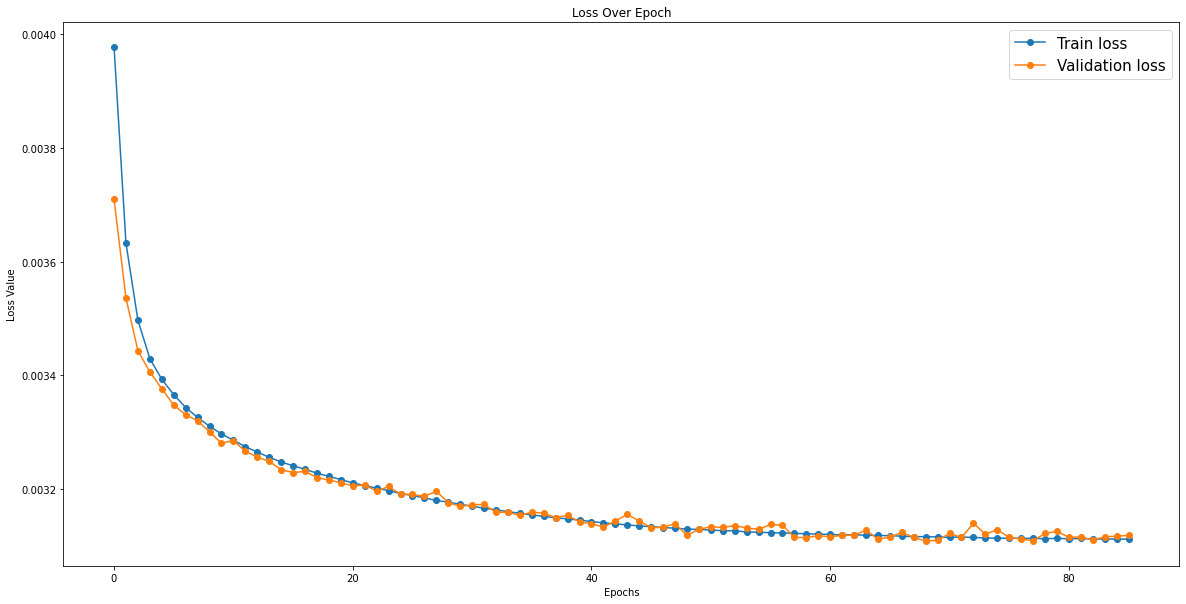

In [38]:
plt.figure(figsize=(20, 10))
plt.title('Loss Over Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
train_curve = plt.plot(history['train_loss'], marker = 'o', label = 'Train loss')
validation_curve = plt.plot(history['validation_loss'], marker = 'o', label = 'Validation loss')
plt.legend(fontsize = 15)
plt.show()

In [39]:
history['validation_loss'].index(min(history['validation_loss']))


68

In [40]:
record_dataset = Cat_Num_Dataset(x, y, embedded_N)
record_loader = DataLoader(record_dataset, batch_size=batch_size,shuffle=False)
df_test=groupFeature(df_test)
xx = df_test.drop(["City_Code_Patient", "patientid"],axis=1, inplace=False)
TestRecord_dataset = Cat_Num_Dataset(xx, xx, embedded_N)
TestRecord_loader = DataLoader(TestRecord_dataset, batch_size=batch_size,shuffle=False)

{'0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4, '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9}


## Predict on training dataset

In [43]:
# Load the unet model at its prime (when it performed the best on the validation set).
state_dict = torch.load(os.path.join(model_save_path, 'Basic_DL_epoch_068.pth'))
net.load_state_dict(state_dict)

# Testing process on test data.
net.eval()

result=[]#np.empty([1, 1])
targetResult=[]#np.empty([1, 1])

for batch, (test_featuresC,test_featuresN, test_target) in enumerate(record_loader):
    # Data prepared to be given as input to model.
    # Predicted output from the input sample.
    target_prediction = net(test_featuresC,test_featuresN)
    p,predicted = torch.max(target_prediction.data, 1)
    predicted=predicted.numpy()
    #print(predicted)
    result=np.append(result,predicted)
    targetResult=np.append(targetResult,test_target.numpy())
accuracy_score(targetResult, result)

0.4047098650286712

In [44]:
df_train = pd.read_csv("train_data.csv")
df_train["StayCat"]=result
df_train.to_csv("train_data_emb.csv") 

## Predict on test dataset

In [45]:
resultt=[]
for batch, (test_featuresC,test_featuresN, test_target) in enumerate(TestRecord_loader):
    # Data prepared to be given as input to model.
    # Predicted output from the input sample.
    target_prediction = net(test_featuresC,test_featuresN)
    p,predicted = torch.max(target_prediction.data, 1)
    predicted=predicted.numpy()
    #print(predicted)
    resultt=np.append(resultt,predicted)


## Save

In [46]:
df_test = pd.read_csv("test_data.csv")
df_test["StayCat"]=resultt
df_test.to_csv("test_data_emb.csv")

In [48]:
df_ID = pd.read_csv("test_data.csv")
dR = {'case_id': df_ID["case_id"]}
d_result = pd.DataFrame(data=dR)

d_result["Stay"]=resultt
d_result['Stay'] = d_result['Stay'].map({0.: '0-10',1.: '11-20', 2.: '21-30',3.: '31-40', 
                                         4.: '41-50',5.: '51-60', 6.: '61-70',7.: '71-80',
                                         8.: '81-90', 9.: '91-100',10.: 'More than 100 Days'})

d_result.to_csv(r'outputE.csv', index = False)